# Classifier

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.enable_eager_execution()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load index csv

In [6]:
dataset_index = pd.read_csv('./dataset/tiles-data/data.csv')
print(dataset_index.shape)
print(dataset_index.head())
print('\n')

dataset_size = dataset_index.shape[0]
num_classes = np.amax(dataset_index['label'])

# append path prefix
dataset_index['image-path'] = './dataset/tiles-resized/' + dataset_index['image-name']

print('append path prefix')
print(dataset_index.shape)
print(dataset_index.head())
print('\n')

# subtract label id by 1
dataset_index['label'] -= 1

print('subtract label id by 1')
print(dataset_index.shape)
print(dataset_index.head())
print('\n')

# train-test split
train_index = dataset_index.sample(frac=0.7) # 70% train
train_size = train_index.shape[0]
test_index = dataset_index.drop(train_index.index)
val_index = test_index.sample(frac=0.5) # 15% val
val_size = val_index.shape[0]
test_index = test_index.drop(val_index.index)
test_size = test_index.shape[0]

print('Train')
print(train_index.shape)
print(train_index.head())
print('\n')
print('Val')
print(val_index.shape)
print(val_index.head())
print('\n')
print('Test')
print(test_index.shape)
print(test_index.head())

(629, 3)
  image-name  label    label-name
0      1.jpg     38  bonus-winter
1      2.jpg     26  characters-8
2      3.jpg      9        dots-9
3      4.jpg     36  bonus-summer
4      5.jpg     28   honors-east


append path prefix
(629, 4)
  image-name  label    label-name                     image-path
0      1.jpg     38  bonus-winter  ./dataset/tiles-resized/1.jpg
1      2.jpg     26  characters-8  ./dataset/tiles-resized/2.jpg
2      3.jpg      9        dots-9  ./dataset/tiles-resized/3.jpg
3      4.jpg     36  bonus-summer  ./dataset/tiles-resized/4.jpg
4      5.jpg     28   honors-east  ./dataset/tiles-resized/5.jpg


subtract label id by 1
(629, 4)
  image-name  label    label-name                     image-path
0      1.jpg     37  bonus-winter  ./dataset/tiles-resized/1.jpg
1      2.jpg     25  characters-8  ./dataset/tiles-resized/2.jpg
2      3.jpg      8        dots-9  ./dataset/tiles-resized/3.jpg
3      4.jpg     35  bonus-summer  ./dataset/tiles-resized/4.jpg
4      5

## Create datasets, preprocessing

train size 28160
val size 6016
test size 6080


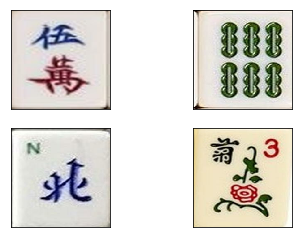

In [9]:
def show_image_sample(ds):
    for n, (image, label) in enumerate(ds.take(4)):
        plt.subplot(2,2,n+1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.show()

def read_image(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [320, 320])
    image /= 255.0 # normalize to [0,1]
    return image

def rotate_image(image, label):
    image = tf.image.rot90(image)
    return image, label

def get_dataset(dataset_index):
    path_ds = tf.data.Dataset.from_tensor_slices(dataset_index['image-path'])
    image_ds = path_ds.map(read_image, num_parallel_calls=AUTOTUNE)
    
    label_one_hot = tf.one_hot(dataset_index['label'], num_classes)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(label_one_hot, tf.int64))
    
    paired_ds = tf.data.Dataset.zip((image_ds, label_ds))
    
    paired_ds_90 = paired_ds.map(rotate_image, num_parallel_calls=AUTOTUNE)
    paired_ds_180 = paired_ds_90.map(rotate_image, num_parallel_calls=AUTOTUNE)
    paired_ds_270 = paired_ds_180.map(rotate_image, num_parallel_calls=AUTOTUNE)
    paired_ds = paired_ds.concatenate(paired_ds_90).concatenate(paired_ds_180).concatenate(paired_ds_270)

    return paired_ds
    
train_ds = get_dataset(train_index)
train_size *= 4
print('train size', train_size)

val_ds = get_dataset(val_index)
val_size *= 4
print('val size', val_size)

test_ds = get_dataset(val_index)
test_size *= 4
print('test size', test_size)

show_image_sample(test_ds)

## Load encoder model

In [10]:
encoder = keras.Sequential(layers=[
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='selu', input_shape=(320,320,3)),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='selu'),
], name='encoder')

# Load weight
encoder.load_weights(filepath='./models/best_encoder_32_adam_0.003_0.9_0.99final.h5')

for layer in encoder.layers:
    layer.trainable = False

## Define fully-connected model

In [11]:
fc = keras.Sequential(layers=[
    keras.layers.Flatten(),
#     keras.layers.Dense(4096, activation='relu'),
#     keras.layers.Dropout(rate=0.3),
#     keras.layers.Dense(2048, activation='relu'),
#     keras.layers.Dropout(rate=0.3),
#     keras.layers.Dense(1024, activation='relu'),
#     keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(rate=0.15),
    keras.layers.Dense(num_classes, activation='softmax')
], name='fc')

## Train classifier model

In [12]:
batch_size = 32
lr = 1e-3
b1 = 0.9
b2 = 0.999
config_str = str(batch_size)+'_adam_'+str(lr)+'_'+str(b1)+'_'+str(b2)+'final'

train_ds_batch = train_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=train_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)
val_ds_batch = val_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=val_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)

classifier = keras.Sequential([encoder, fc])
optim = keras.optimizers.Adam(lr=lr, beta_1=b1, beta_2=b2)
classifier.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

classifier.fit(train_ds_batch,
               epochs=20,
               steps_per_epoch=int(train_size/batch_size),
               validation_data=val_ds_batch,
               validation_steps=int(val_size/batch_size),
               callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/classifier/'+config_str)]
            )

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/20
Instructions for updating:
Use tf.cast instead.
880/880 [==============================] - 82s 93ms/step - loss: 15.6937 - acc: 0.0256 - val_loss: 15.7752 - val_acc: 0.0213
Epoch 2/20
582/880 [==================>...........] - ETA: 20s - loss: 15.7191 - acc: 0.0248

KeyboardInterrupt: 

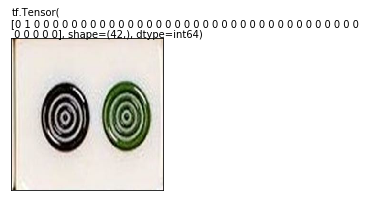

[1.3780718e-04 9.9100363e-01 7.9620554e-07 1.2985495e-05 6.6571607e-07
 2.1265139e-06 1.0151489e-06 1.7999148e-05 4.0660533e-09 2.1915750e-05
 2.0016053e-06 8.3289969e-08 7.6269251e-03 1.2312636e-06 1.8320917e-09
 6.6929129e-10 9.4667375e-06 1.7233133e-07 3.8360604e-08 2.8828090e-06
 2.3299478e-06 2.7304497e-05 2.0138354e-05 2.0359152e-05 7.1128215e-07
 5.5789869e-06 6.0280963e-06 7.4922384e-05 1.1071903e-04 1.0927331e-04
 3.1829003e-04 9.3828456e-09 2.8683845e-04 3.3136762e-09 4.4154258e-06
 1.0815246e-06 1.1252078e-07 2.7899364e-06 1.6385634e-04 1.3623960e-06
 1.4152390e-06 5.9287646e-07]


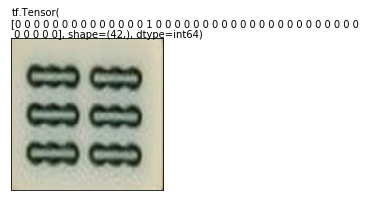

[2.7385322e-06 2.9315632e-07 1.2410269e-06 6.0426751e-06 2.0718062e-06
 8.9911060e-05 9.0938454e-05 4.5122379e-03 1.1159915e-03 1.5245469e-06
 1.2878199e-07 1.3716343e-05 1.1323368e-04 8.6514789e-05 9.7939634e-01
 2.3683495e-05 1.2830849e-03 9.7620524e-03 1.4249708e-06 8.2582750e-07
 6.7514139e-07 1.5232950e-05 1.8971664e-06 6.0043510e-07 8.5431043e-07
 2.7233723e-04 2.4788756e-06 1.0404262e-06 2.5697525e-05 4.4709530e-05
 8.7930428e-05 6.7550076e-07 1.0480351e-05 7.7135162e-04 6.1883598e-05
 7.0928785e-05 6.4047112e-05 3.5279070e-04 7.6258102e-06 1.1913711e-03
 1.1851463e-04 3.9288579e-04]


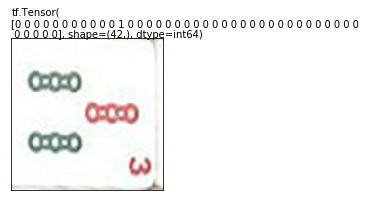

[2.1214511e-05 2.1874597e-05 1.2841065e-01 8.1770704e-05 3.4543456e-04
 4.9995633e-05 3.0516194e-05 3.0448695e-05 1.3546027e-04 2.3911434e-04
 7.7976580e-03 1.1129845e-01 1.9516764e-04 3.9979727e-03 9.5661144e-06
 1.1110855e-03 2.6158566e-04 4.4181311e-04 3.3474472e-01 1.8606678e-01
 5.6749596e-03 8.2136273e-02 4.8640268e-03 1.7367378e-03 8.2907332e-03
 4.0339500e-02 2.3013491e-03 2.2996619e-05 8.3728453e-05 1.8987337e-03
 3.4436607e-04 5.2374639e-03 9.3979113e-05 1.0020663e-03 6.1461474e-03
 1.9721242e-02 1.9624755e-04 8.1337341e-05 1.3276054e-02 1.2917299e-02
 1.4963902e-02 3.3795414e-03]


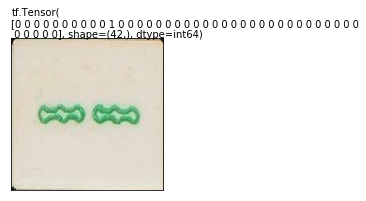

[3.2548338e-15 6.7320505e-10 3.5223537e-09 7.7591315e-14 1.3544682e-16
 2.9475181e-14 8.4530585e-16 2.0236898e-13 2.0319902e-13 2.5506222e-07
 9.9991202e-01 2.0057321e-06 3.0567251e-14 1.4601442e-09 6.2967026e-16
 1.3006017e-07 7.4920024e-14 2.8220107e-13 1.7446505e-08 3.6903059e-06
 3.3075349e-07 9.4931430e-08 1.6355155e-08 2.8607943e-08 7.5782766e-05
 3.9953584e-08 1.4791837e-08 2.3282015e-08 1.0828851e-09 2.1757900e-10
 9.8425609e-08 5.3703211e-06 5.0487157e-09 2.3650667e-13 9.2269525e-09
 3.0393559e-09 5.2694446e-17 1.6035575e-12 2.4600428e-11 1.1976940e-07
 5.4973671e-11 3.0535528e-08]
1/1 [==============================] - 5s 5s/step - loss: 2.1551 - acc: 0.4688


[2.155099868774414, 0.46875]

In [9]:
test_ds_batch = test_ds.batch(batch_size).repeat().prefetch(AUTOTUNE)

batch = test_ds_batch.take(1)
predict = classifier.predict(batch.make_one_shot_iterator(), steps=1)

for images, labels in batch:
    for i in range(4):
        image = images[i]
        label = labels[i]
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.text(1, 0, label)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        print(predict[i]) 

classifier.evaluate(test_ds_batch.make_one_shot_iterator(), steps=1)